In [21]:
import string

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3
import os
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Embedding, 
    TimeDistributed, Dense, RepeatVector, 
    Activation, Flatten, Reshape, concatenate,  
    Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [23]:
#define the constants

WIDTH = 299
HEIGHT = 299
OUTPUT_DIM = 2048
max_length = 47
vocab_size = 2039
embedding_dim = 200
START = "<start>"
STOP = "<end>"

In [3]:
encode_model = InceptionV3(weights='imagenet')
encode_model = Model(encode_model.input, encode_model.layers[-2].output)
preprocess_input = tensorflow.keras.applications.inception_v3.preprocess_input

In [4]:
def encodeImage(img):
  # Resize all images to a standard size (specified bythe image 
  # encoding network)
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  # Convert a PIL image to a numpy array
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array
  x = np.expand_dims(x, axis=0)
  # Perform any preprocessing needed by InceptionV3 or others
  x = preprocess_input(x)
  # Call InceptionV3 (or other) to extract the smaller feature set for 
  # the image.
  x = encode_model.predict(x) # Get the encoding vector for the image
  # Shape to correct form to be accepted by LSTM captioning network.
  x = np.reshape(x, OUTPUT_DIM )
  return x

In [7]:
root_captioning = "./finalprogpickle/"
train_path = os.path.join(root_captioning,"data",f'train{OUTPUT_DIM}.pkl')
with open(train_path, "rb") as fp:
  encoding_train = pickle.load(fp)

In [8]:
wordtoidx_path = "./finalprogpickle/data/wordtoidx.pkl"
with open(wordtoidx_path, "rb") as fp:
  wordtoidx = pickle.load(fp)

idxtoword_path = "./finalprogpickle/data/idxtoword.pkl"
with open(idxtoword_path, "rb") as fp:
  idxtoword = pickle.load(fp)

In [9]:
def data_generator(descriptions, photos, wordtoidx, \
                   max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[key]
      # Each photo has 5 descriptions
      for desc in desc_list:
        # Convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ') \
               if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0

In [10]:
# embedding_matrix.shape

In [11]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [12]:
#caption_model.summary()

In [16]:
# caption_model.layers[2].set_weights([embedding_matrix])
# caption_model.layers[2].trainable = False
# caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [17]:
model_path = "./caption_model/caption-model.hdf5"
caption_model.load_weights(model_path)

In [18]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [25]:
img_path = input('Enter the path to the image')

Enter the path to the image./test.jpg


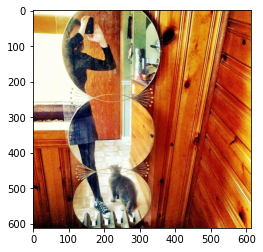

(1, 2048)
Caption: A cat is sitting on a table next to a window.
_____________________________________


In [26]:
#img_path = "./temp.jpg"

img = Image.open(img_path)
img.load()

plt.imshow(img)
plt.show()

img = encodeImage(img).reshape((1,OUTPUT_DIM))
print(img.shape)
print("Caption:",generateCaption(img))
print("_____________________________________")

